In [1]:
from matplotlib import pyplot as plt
import os
import pandas as pd
import numpy as np
import seaborn as sns
from torchvision.transforms import v2

import warnings
warnings.filterwarnings("ignore")

/work/ka1176/caroline/gitlab/AI4EO-MapYourCity/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation, SegformerImageProcessor
from PIL import Image
import requests
import torch

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-512-1024")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-512-1024")
processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-512-1024")

Description
---

- Use the pretrained NVIDIA Segformer model to classify pixels
- Select only class 2
- Save image, masked pixels filled with 0 --> street_segm0.jpg
- Create bounding box containing the class 2 pixels, save image --> street_segmbbox.jpg

In [3]:
data_root = '/work/ka1176/caroline/gitlab/AI4EO-MapYourCity/data/AI4EO-MapYourCity/v1/building-age-dataset'

In [7]:
split = 'train'
data_path = os.path.join(data_root, split, 'data')

In [8]:
df = pd.read_csv(os.path.join(data_root, split, f'{split}-set.csv'))
df.head()

,label,country_id,pid,city_id
0,5,QCD,z5tkosm85q,4VAXW
1,1,QCD,nqblpfzyv6,4VAXW
2,5,QCD,2ume6kkg36,4VAXW
3,1,QCD,e2k9hq8wdy,4VAXW
4,5,QCD,nputhcozta,4VAXW


In [9]:
source_filename = 'street.jpg'
target_filename = 'street_segm0.jpg'
target_bb_filename = 'street_segmbox.jpg'

In [10]:
overwrite = False

In [18]:
problem_pids = ['bdpfdxr3yo', 'g3gzdwy6t8']

In [19]:
for pid in problem_pids:#df['pid'].values[::-1]:
    
    if not os.path.exists(os.path.join(data_path, pid, source_filename)):
        print('missing source', pid)
        continue
    
    if os.path.exists(os.path.join(data_path, pid, target_filename)) and \
       os.path.exists(os.path.join(data_path, pid, target_bb_filename)):
        if not overwrite: continue    
    
    with open(os.path.join(data_path, pid, source_filename), 'rb') as ff:
        image = Image.open(ff)
        image.load()
        image = image.convert("RGB")
        raw = plt.imread(os.path.join(data_path, pid, source_filename))
        
        # Segment
        inputs = feature_extractor(images=image, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
            
        # Get predicted map
        predicted_segmentation_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
        predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
        
        # Mask: Keep only class 2 (which I assume is "house")
        if not 2 in np.unique(predicted_segmentation_map):
            print(f'Class not found in PID {pid}: Keep original image')
            image.save(os.path.join(data_path, pid, target_filename))
            image.save(os.path.join(data_path, pid, target_bb_filename))
            continue
        mask = np.ma.make_mask(predicted_segmentation_map==2)
        masked_raw = np.where(np.dstack([mask, mask, mask]), raw, 0)
        
        # Bounding box encompassing the house in the segmentation map
        segmentation = np.where(mask==True)
        x_min = int(np.min(segmentation[1]))
        x_max = int(np.max(segmentation[1]))
        y_min = int(np.min(segmentation[0]))
        y_max = int(np.max(segmentation[0]))
        bb = raw[y_min:y_max, x_min:x_max]
                
        # Save as image
        masked_image = Image.fromarray(masked_raw)
        masked_image.save(os.path.join(data_path, pid, target_filename))
        
        bbox_image = Image.fromarray(bb)
        bbox_image.save(os.path.join(data_path, pid, target_bb_filename))
        print(f'Targets created for PID {pid}')

Class not found in PID g3gzdwy6t8: Keep original image


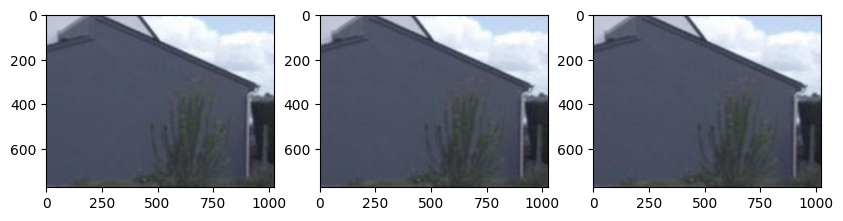

In [20]:
fig, ax = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(10, 10))
#pid = 'd8cwuujz5b'
ax[0].imshow(plt.imread(os.path.join(data_path, pid, source_filename)))
ax[1].imshow(plt.imread(os.path.join(data_path, pid, target_filename)));
ax[2].imshow(plt.imread(os.path.join(data_path, pid, target_bb_filename)));